In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, f1_score, auc

from imbalanced_ensemble.visualizer import ImbalancedEnsembleVisualizer
from imbalanced_ensemble.ensemble import (
   SelfPacedEnsembleClassifier,
   RUSBoostClassifier,
   SMOTEBoostClassifier,
    AdaUBoostClassifier,
    CompatibleAdaBoostClassifier,
    OverBoostClassifier
)

#### Reading Data From csv - Customer Churn Prediction

In [2]:
data = pd.read_csv("Churn_Modelling.csv")
data_copy = data.copy()
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


##### Checking Columns Types

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


##### Checking Null Values in each column

In [4]:
data.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

##### Checking Unique Values in each column

In [5]:
data.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

##### Column Name which is not in numeric formet and check the unique categories

In [6]:
for i in data.columns:
    if data[i].dtypes == "object":
        print("\nColumn Name:",i)
        print(data[i].unique())
        print("Unique Values:",len(data[i].unique()))


Column Name: Surname
['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']
Unique Values: 2932

Column Name: Geography
['France' 'Spain' 'Germany']
Unique Values: 3

Column Name: Gender
['Female' 'Male']
Unique Values: 2


##### One Hot Encoding

In [7]:
ohe = OneHotEncoder()

converted_cols = ohe.fit_transform(data[["Geography","Gender"]]).toarray()
data = data.drop(["Geography","CustomerId","Gender","Surname"], axis = 1)

Converted_Cols = list()
for i in ohe.categories_:
    Converted_Cols.extend(i)
    
data[Converted_Cols] = converted_cols

##### Plotting the Imbalance in Dataset

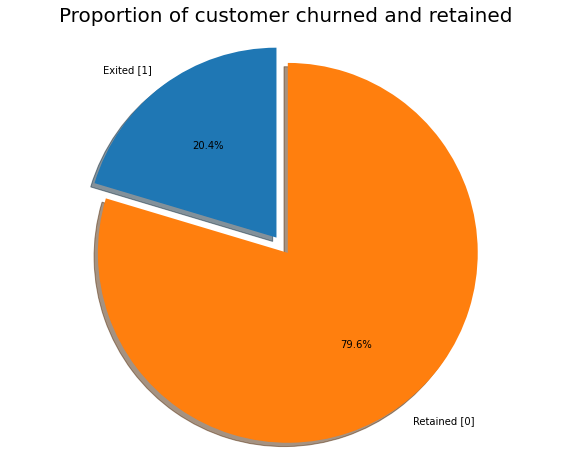

In [8]:
labels = 'Exited [1]', 'Retained [0]'
sizes = [data.Exited[data['Exited']==1].count(), data.Exited[data['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

##### Value Distribution Chart

<AxesSubplot:xlabel='IsActiveMember', ylabel='count'>

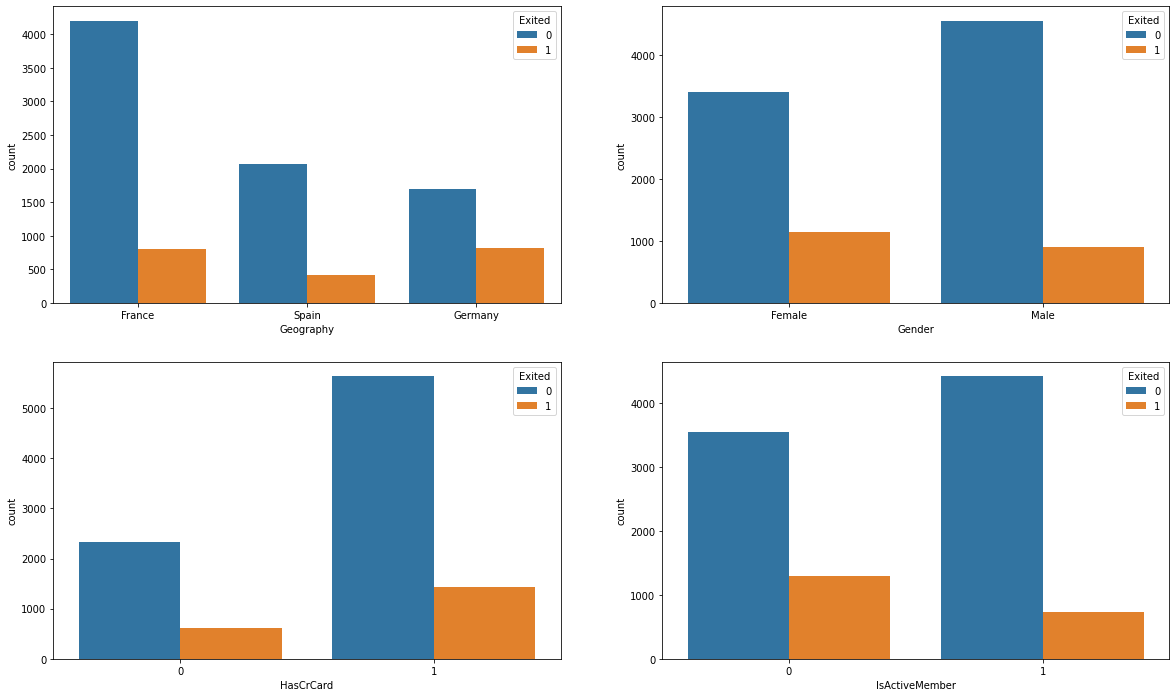

In [9]:
# We first review the 'Status' relation with categorical variables
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geography', hue = 'Exited',data = data_copy, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = data_copy, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = data_copy, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited', data = data_copy, ax=axarr[1][1])

##### Split Data into Train and Test Dataset

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data.drop("Exited", axis = 1), data.Exited, 
                                                    stratify=data.Exited, test_size=0.1, random_state=4)

print("Shape of X", X_train.shape)
print("Shape of y", X_test.shape)

Shape of X (9000, 14)
Shape of y (1000, 14)


##### Scaling the values 

In [11]:
sc = StandardScaler()
sc.fit(X_train)

X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

##### Comparing Different Models which are specially designed for imabalanced dataset

In [12]:
ensembles = {
    "SelfPaced": SelfPacedEnsembleClassifier().fit(X_train_sc, y_train, eval_datasets = {'valid' : (X_test_sc, y_test)}),
    "RUSBoost": RUSBoostClassifier().fit(X_train_sc, y_train, eval_datasets = {'valid' : (X_test_sc, y_test)}),
    "SMOTEBoost": SMOTEBoostClassifier().fit(X_train_sc, y_train, eval_datasets = {'valid' : (X_test_sc, y_test)}),
    "AdaUBoost": AdaUBoostClassifier().fit(X_train_sc, y_train, eval_datasets = {'valid' : (X_test_sc, y_test)}),
    "Compatible": CompatibleAdaBoostClassifier().fit(X_train_sc, y_train, eval_datasets = {'valid' : (X_test_sc, y_test)}),
    "OverBoost": OverBoostClassifier().fit(X_train_sc, y_train, eval_datasets = {'valid' : (X_test_sc, y_test)}),
    
}

visualizer = ImbalancedEnsembleVisualizer().fit(
    ensembles = ensembles,
    granularity = 5
)

Visualizer evaluating model SelfPaced  on dataset train :: 100%|██████████████████████| 50/50 [00:00<00:00, 136.24it/s]
Visualizer evaluating model SelfPaced  on dataset valid :: 100%|██████████████████████| 50/50 [00:00<00:00, 756.73it/s]
Visualizer evaluating model  RUSBoost  on dataset train :: 100%|██████████████████████| 50/50 [00:00<00:00, 205.94it/s]
Visualizer evaluating model  RUSBoost  on dataset valid :: 100%|██████████████████████| 50/50 [00:00<00:00, 716.00it/s]
Visualizer evaluating model SMOTEBoost on dataset train :: 100%|██████████████████████| 50/50 [00:00<00:00, 205.44it/s]
Visualizer evaluating model SMOTEBoost on dataset valid :: 100%|██████████████████████| 50/50 [00:00<00:00, 871.77it/s]
Visualizer evaluating model AdaUBoost  on dataset train :: 100%|██████████████████████| 50/50 [00:00<00:00, 206.20it/s]
Visualizer evaluating model AdaUBoost  on dataset valid :: 100%|██████████████████████| 50/50 [00:00<00:00, 915.06it/s]
Visualizer evaluating model Compatible o

Visualizer computing confusion matrices............ Finished!


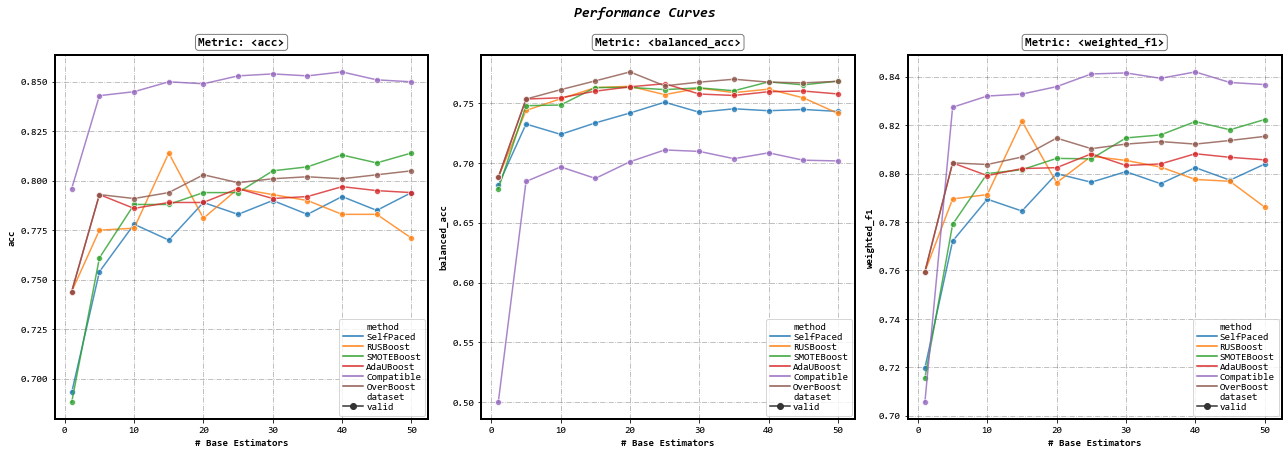

In [13]:
_ = visualizer.performance_lineplot(on_datasets= ["valid"], sub_figsize = (6,6))

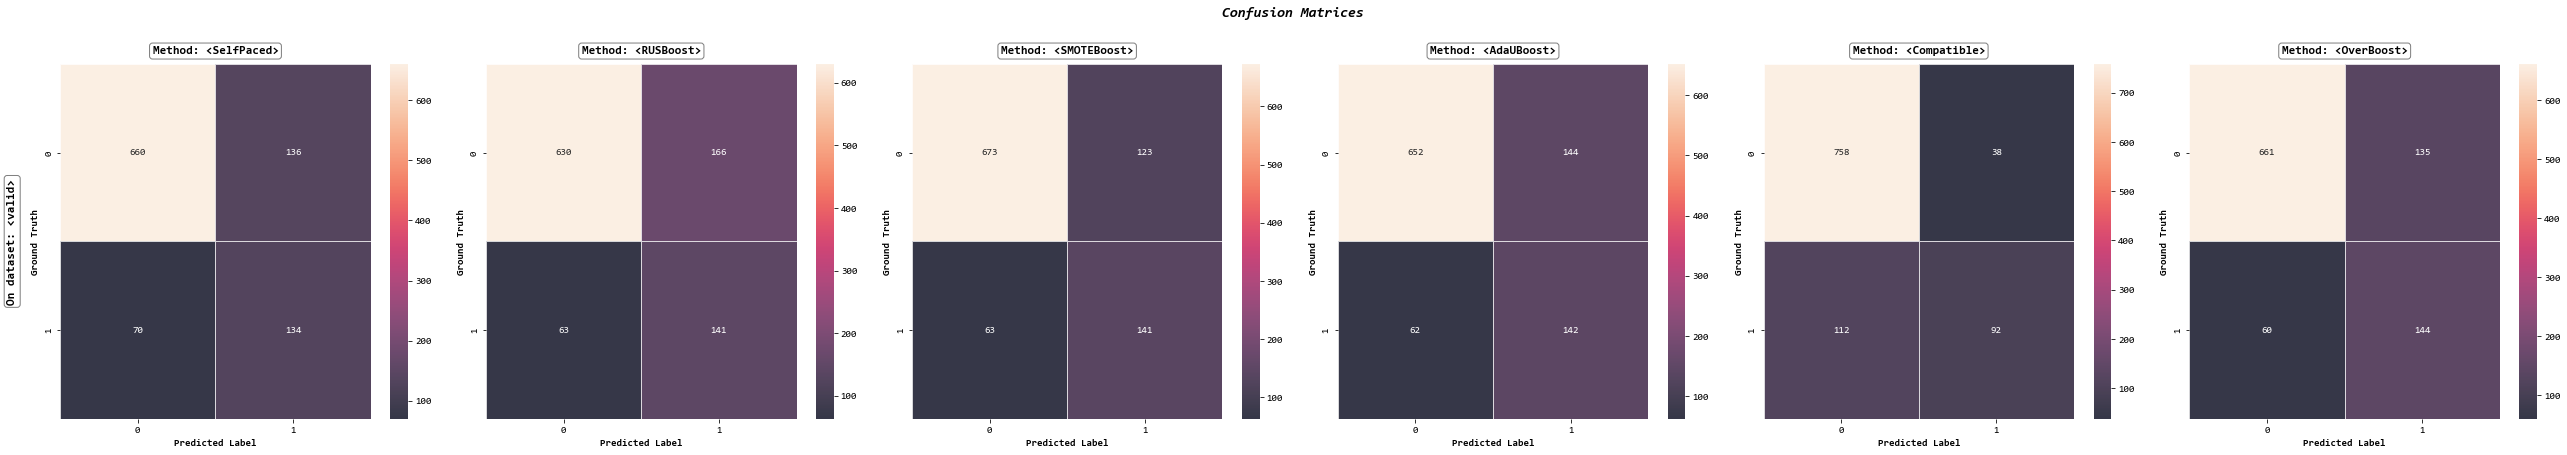

In [14]:
_ = visualizer.confusion_matrix_heatmap(on_datasets= ["valid"], sub_figsize = (6,6))

##### Classification report of top 2 models after comparing each model

In [15]:
model = AdaUBoostClassifier()
model2 = CompatibleAdaBoostClassifier()

model.fit(X_train_sc, y_train)
model2.fit(X_train_sc, y_train)

pred = model.predict(X_test_sc)
pred2 = model2.predict(X_test_sc)

print("AdaUBoost")
print(classification_report(y_test, pred))
print("\n Compatible")
print(classification_report(y_test, pred2))

AdaUBoost
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       796
           1       0.50      0.70      0.58       204

    accuracy                           0.79      1000
   macro avg       0.70      0.76      0.72      1000
weighted avg       0.83      0.79      0.81      1000


 Compatible
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       796
           1       0.71      0.45      0.55       204

    accuracy                           0.85      1000
   macro avg       0.79      0.70      0.73      1000
weighted avg       0.84      0.85      0.84      1000



##### ROC Curve

AdaUBoostClassifier: ROC AUC=0.758
CompatibleAdaBoostClassifier: ROC AUC=0.702


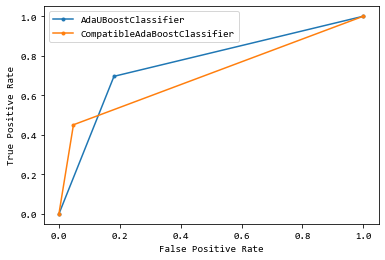

In [16]:
adu_auc = roc_auc_score(y_test, pred)
print('AdaUBoostClassifier: ROC AUC=%.3f' % (adu_auc))

Comp_auc = roc_auc_score(y_test, pred2)
print('CompatibleAdaBoostClassifier: ROC AUC=%.3f' % (Comp_auc))

roc_auc_fpr, roc_auc_tpr, _ = roc_curve(y_test, pred)
Comp_auc_fpr, Comp_auc_tpr, _ = roc_curve(y_test, pred2)


plt.plot(roc_auc_fpr, roc_auc_tpr, marker='.', label='AdaUBoostClassifier')
plt.plot(Comp_auc_fpr, Comp_auc_tpr, marker='.', label='CompatibleAdaBoostClassifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show()

##### Precision Recall Curve

AdaUBoostClassifier: f1=0.580 auc=0.627
CompatibleAdaBoostClassifier: f1=0.551 auc=0.635


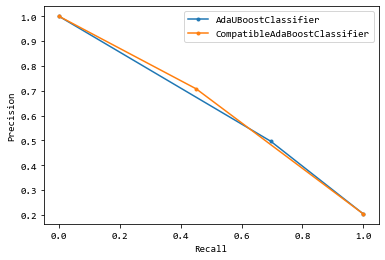

In [17]:
Au_precision, Au_recall, _ = precision_recall_curve(y_test, pred)
Au_f1, Au_auc = f1_score(y_test, pred), auc(Au_recall, Au_precision)
print('AdaUBoostClassifier: f1=%.3f auc=%.3f' % (Au_f1, Au_auc))
plt.plot(Au_recall, Au_precision, marker='.', label='AdaUBoostClassifier')

Comp_precision, Comp_recall, _ = precision_recall_curve(y_test, pred2)
Comp_f1, Comp_auc = f1_score(y_test, pred2), auc(Comp_recall, Comp_precision)
print('CompatibleAdaBoostClassifier: f1=%.3f auc=%.3f' % (Comp_f1, Comp_auc))
plt.plot(Comp_recall, Comp_precision, marker='.', label='CompatibleAdaBoostClassifier')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

##### Calculating the weights for neural network

In [18]:
class0 = data[data.Exited == 0]
class1 = data[data.Exited == 1]

numpC0 = class0["Exited"].to_numpy()
numpC1 = class1["Exited"].to_numpy()

concateTogather = np.concatenate((numpC0, numpC1))
uniqueAll = np.unique(concateTogather)

weights = sklearn.utils.class_weight.compute_class_weight('balanced', classes = uniqueAll, y = concateTogather)

c_weights = {
    0 : weights[0],
    1 : weights[1]
}

print("Weights of different classes")
print(c_weights) ## It means we need to put more weight on class 1

Weights of different classes
{0: 0.6279040562602034, 1: 2.454590083456063}


#####  Model Building

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_test_sc.shape[1],)),
    tf.keras.layers.Dense(1500, activation='relu'),
    tf.keras.layers.Dense(750, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

##### Checking the model parameters

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1500)              22500     
                                                                 
 dense_1 (Dense)             (None, 750)               1125750   
                                                                 
 dense_2 (Dense)             (None, 300)               225300    
                                                                 
 dense_3 (Dense)             (None, 100)               30100     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,403,751
Trainable params: 1,403,751
Non-trainable params: 0
_________________________________________________________________


##### Compile Model

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

##### Training Model

In [22]:
model.fit(X_train_sc, y_train, 
          epochs=50, 
          validation_data=(X_test_sc, y_test), 
          class_weight=c_weights,
          )

Epoch 1/50
282/282 [==============================] - 2s 3ms/step - loss: 0.5327 - accuracy: 0.7402 - val_loss: 0.4596 - val_accuracy: 0.8120
Epoch 2/50
282/282 [==============================] - 1s 2ms/step - loss: 0.4843 - accuracy: 0.7787 - val_loss: 0.4464 - val_accuracy: 0.7980
Epoch 3/50
282/282 [==============================] - 1s 2ms/step - loss: 0.4688 - accuracy: 0.8038 - val_loss: 0.5000 - val_accuracy: 0.7610
Epoch 4/50
282/282 [==============================] - 1s 2ms/step - loss: 0.4575 - accuracy: 0.7996 - val_loss: 0.4702 - val_accuracy: 0.8090
Epoch 5/50
282/282 [==============================] - 1s 2ms/step - loss: 0.4502 - accuracy: 0.8054 - val_loss: 0.4501 - val_accuracy: 0.8010
Epoch 6/50
282/282 [==============================] - 1s 2ms/step - loss: 0.4448 - accuracy: 0.7977 - val_loss: 0.4158 - val_accuracy: 0.8230
Epoch 7/50
282/282 [==============================] - 1s 2ms/step - loss: 0.4397 - accuracy: 0.8104 - val_loss: 0.4526 - val_accuracy: 0.7870
Epoch 

##### Accuracy of Neural Nets

In [23]:
print("Accuracy")
pred_tf = model.predict(X_test_sc)
print(model.evaluate(X_test_sc, y_test))

print("\n\nNeural Network")
print(classification_report(y_test, pred_tf >= 0.5))

Accuracy
32/32 [==============================] - 0s 1ms/step - loss: 1.3479 - accuracy: 0.8100
[1.347923755645752, 0.8100000023841858]


Neural Network
              precision    recall  f1-score   support

           0       0.89      0.86      0.88       796
           1       0.53      0.60      0.56       204

    accuracy                           0.81      1000
   macro avg       0.71      0.73      0.72      1000
weighted avg       0.82      0.81      0.81      1000



##### ROC Curve Neural Nets and compoaring with other 

Neural Network: ROC AUC=0.733


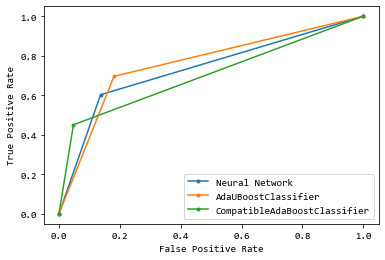

In [24]:
NN_auc = roc_auc_score(y_test, pred_tf >= 0.5)
print('Neural Network: ROC AUC=%.3f' % (NN_auc))

NN_auc_fpr, NN_auc_tpr, _ = roc_curve(y_test, pred_tf >= 0.5)

plt.plot(NN_auc_fpr, NN_auc_tpr, marker='.', label='Neural Network')
plt.plot(roc_auc_fpr, roc_auc_tpr, marker='.', label='AdaUBoostClassifier')
plt.plot(Comp_auc_fpr, Comp_auc_tpr, marker='.', label='CompatibleAdaBoostClassifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show()

##### Precision Recall Currve Neural Network comparing with other

Neural Network: f1=0.564 auc=0.607


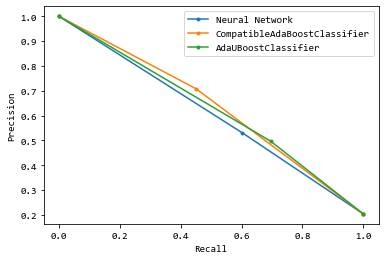

In [25]:
NN_precision, NN_recall, _ = precision_recall_curve(y_test, pred_tf >= 0.5)
NN_f1, NN_auc = f1_score(y_test, pred_tf >= 0.5), auc(NN_recall, NN_precision)
print('Neural Network: f1=%.3f auc=%.3f' % (NN_f1, NN_auc))
plt.plot(NN_recall, NN_precision, marker='.', label='Neural Network')
plt.plot(Comp_recall, Comp_precision, marker='.', label='CompatibleAdaBoostClassifier')
plt.plot(Au_recall, Au_precision, marker='.', label='AdaUBoostClassifier')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()